# __Model Visualisation__

### __Deep Learning__

#### __Project: Image Captioning with Visual Attention__

In [1]:
import os
os.chdir(os.environ["PYTHONPATH"])

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import scripts.data_loading as dl
import scripts.data_processing as dp
import scripts.visualization as vis
import scripts.model as model

%load_ext autoreload
%autoreload 2

### Word Embeddings layer Visualisation

In [2]:
DECODER_PATH = "./models/best_models/best_model_e256_a256_d512_lr9e-05.pth"

In [3]:
def load_decoder(state_path: str) -> model.LSTMDecoder:
    decoder_state = torch.load(state_path, map_location=torch.device("cpu"))["decoder"]

    num_embeddings = decoder_state["word_embedding.weight"].shape[0]
    embedding_dim = decoder_state["word_embedding.weight"].shape[1]
    encoder_dim = 196
    attention_dim = decoder_state["attention.W_1.weight"].shape[0]
    decoder_dim = decoder_state["init_c.weight"].shape[0]

    decoder = model.LSTMDecoder(
        num_embeddings, embedding_dim, encoder_dim, decoder_dim, attention_dim
    )
    decoder.load_state_dict(decoder_state)

    return decoder

In [4]:
decoder = load_decoder(DECODER_PATH)
embeddings = decoder.word_embedding.weight.detach().numpy()

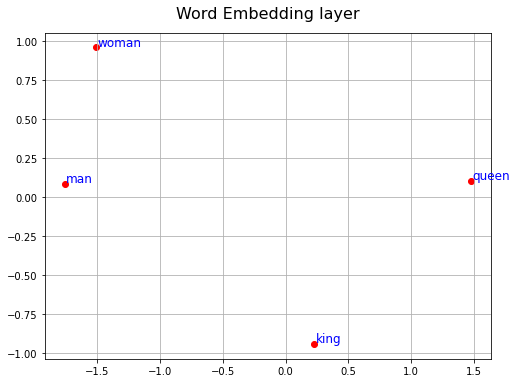

In [68]:
plt.rcParams["figure.figsize"] = (8, 6)

plt.title("Word Embedding layer", fontsize=16, y=1.025)
plt.grid('on')
vis.plot_embeddings(embeddings, ["man", "woman", "king", "queen"], out_path="./word_embedding.png")

In [ ]:
del decoder, embeddings

### Attention Context Visualisation

In [5]:
MODEL_PATH = "./models/best_models/best_model_e256_a256_d512_lr9e-05.pth"
state_dict = torch.load(MODEL_PATH)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

decoder = model.LSTMDecoder(num_embeddings=10_004, embedding_dim=256, encoder_dim=196, decoder_dim=512, attention_dim=256)
decoder.load_state_dict(state_dict["decoder"])
decoder.to(device)

encoder = model.VGG19Encoder()
encoder.to(device)

print("Loading FINISHED")

Loading FINISHED


In [6]:
root = dl.DATASET_PATHS[dl.DatasetType.TEST].images
ann_json = dl.DATASET_PATHS[dl.DatasetType.TEST].captions_json

coco = torchvision.datasets.CocoCaptions(root, ann_json)
coco_preprocessed_img = torchvision.datasets.CocoCaptions(root, ann_json, dp.VGGNET_PREPROCESSING_PIPELINE)
vocabulary = dp.Vocabulary()

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


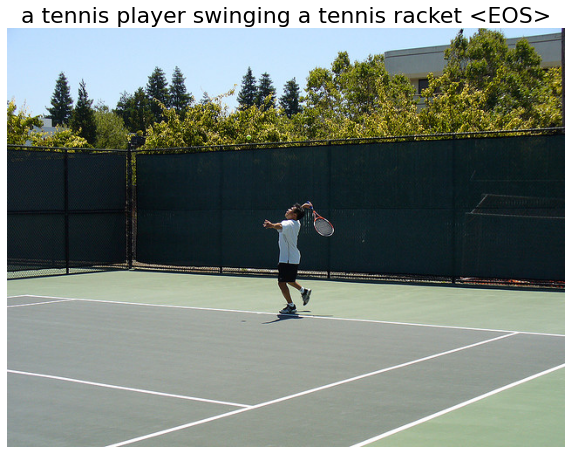

In [39]:
index = 24
image, _ = coco[index]
img, _ = coco_preprocessed_img[index]

img = img.to(device)
feature_maps, feature_mean = encoder.forward(img.unsqueeze(0))

sequence, contexts, betas = decoder.greedy_decoding(
    feature_maps=feature_maps,
    feature_mean=feature_mean,
    start_token_index=vocabulary.word2idx("<SOS>"),
    end_token_index=vocabulary.word2idx("<EOS>"),
    max_length=100
)

sequence = dp.TextPipeline.decode_caption(vocabulary, sequence)
sequence = sequence + ' <EOS>'  

plt.rcParams["figure.figsize"] = (10, 10)
plt.axis('off')
plt.title(sequence, fontsize=22)
plt.imshow(image)

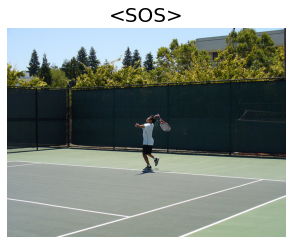

In [63]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.title("<SOS>", fontsize=20)
plt.axis('off')
plt.imshow(image)
plt.savefig("start.png", dpi=100)
#plt.imshow(image)
#image = np.array(image)
#sequence = sequence.split()

In [41]:
def plot_context(word_index):
    context = contexts[word_index].cpu().detach().view(14, 14).numpy()

    plt.title(sequence[word_index], fontsize=20)
    plt.axis('off')
    vis.plot_context(image, (224, 224), context, betas[word_index])

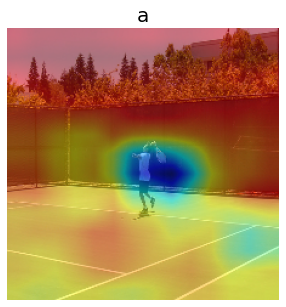

In [54]:
plot_context(0)
plt.savefig("att0.png", dpi=100)

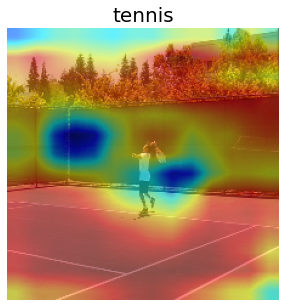

In [55]:
plot_context(1)
plt.savefig("att1.png", dpi=100)

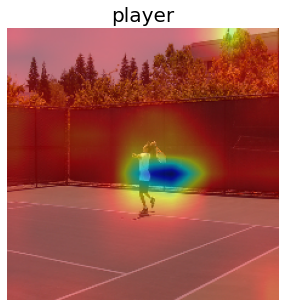

In [56]:
plot_context(2)

plt.savefig("att2.png", dpi=100)

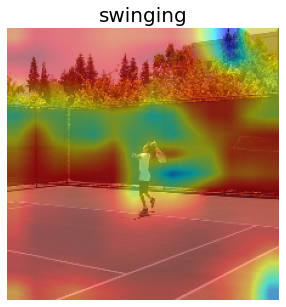

In [57]:
plot_context(3)

plt.savefig("att3.png", dpi=100)

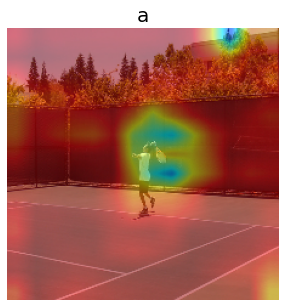

In [58]:
plot_context(4)

plt.savefig("att4.png", dpi=100)

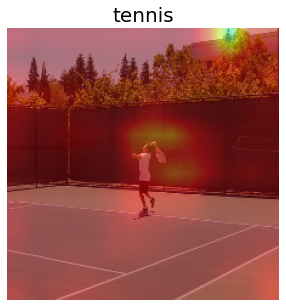

In [59]:
plot_context(5)

plt.savefig("att5.png", dpi=100)

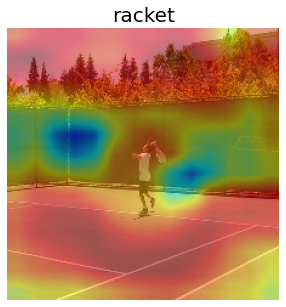

In [60]:
plot_context(6)

plt.savefig("att6.png", dpi=100)

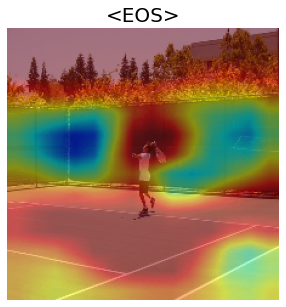

In [61]:
plot_context(7)


plt.savefig("att7.png", dpi=100)

### Beta coefficients

In [50]:
sequence

['a', 'tennis', 'player', 'swinging', 'a', 'tennis', 'racket', '<EOS>']

In [51]:
betas

[0.9999068975448608,
 0.9997960925102234,
 0.9967779517173767,
 0.970699667930603,
 0.8042980432510376,
 0.5368609428405762,
 0.8246291875839233,
 0.8461178541183472]

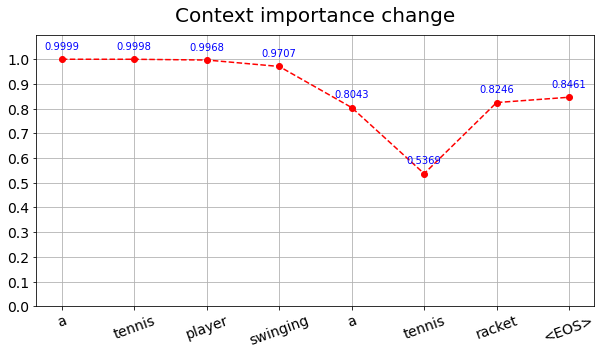

In [53]:
plt.rcParams["figure.figsize"] = (10, 5)

plt.title("Context importance change", fontsize=20, y=1.025)
plt.tick_params(labelsize=14)
plt.grid("on")
vis.plot_betas(betas, sequence)
plt.savefig("influence_beta.png", dpi=100)